# Importing Required Libraries

# Resume Screening and Ranking System

## Overview

This notebook implements an end-to-end **automated resume screening and ranking system** that combines machine learning classification with information retrieval techniques. The system addresses two fundamental challenges in recruitment automation:

1. **Resume Screening**: Multi-class classification to categorize resumes into predefined job categories using supervised learning
2. **Resume Ranking**: Similarity-based ranking to identify the best candidate-job fit using TF-IDF vectorization and cosine similarity



In [2]:
# ============================================================================
# INSTALL REQUIRED PACKAGES (run first - ensures environment compatibility)
# ============================================================================
import subprocess
import sys

def install_package(package):
    """Install package if not available."""
    try:
        __import__(package.split('[')[0])  # Handle package[extras] format
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])
        print(f"✅ {package} installed successfully")

# Install all required packages
required_packages = [
    'wordcloud', #Visual representation of term frequency
    'xgboost',
    'imbalanced-learn',
    'joblib',
    'pypdf',
    'nltk',
    'scikit-learn',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn'
]

for pkg in required_packages:
    install_package(pkg)

print("\n" + "="*70)
print("📦 PACKAGE INSTALLATION COMPLETE")
print("="*70)

✅ wordcloud already installed
✅ xgboost already installed
📦 Installing imbalanced-learn...
✅ imbalanced-learn installed successfully
✅ joblib already installed
📦 Installing pypdf...
✅ pypdf installed successfully
✅ nltk already installed
📦 Installing scikit-learn...
✅ scikit-learn installed successfully
✅ pandas already installed
✅ numpy already installed
✅ matplotlib already installed
✅ seaborn already installed

📦 PACKAGE INSTALLATION COMPLETE


In [3]:
# ============================================================================
# IMPORT ALL LIBRARIES
# ============================================================================

# Standard library imports
import os
import re
import warnings
from pathlib import Path
from datetime import datetime

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning - sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# XGBoost (optional)
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
    print("✅ XGBoost available")
except Exception as e:
    HAS_XGBOOST = False
    print(f"⚠️  XGBoost unavailable ({type(e).__name__}). XGBoost pipeline will be skipped.")

# SMOTE for class imbalance
from imblearn.over_sampling import SMOTE

# Model persistence
import joblib #Model serialization and persistence

# PDF processing
from pypdf import PdfReader #PDF text extraction for document processing

# NLP - NLTK
import nltk #Tokenization, stopword removal, and lemmatization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data (run once)
print("\n📥 Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Initialize WordNet Lemmatizer
try:
    LEMMATIZER = WordNetLemmatizer()
    HAS_LEMMATIZER = True
except:
    HAS_LEMMATIZER = False
    print("⚠️  Lemmatization unavailable. Install with: pip install nltk")

print("\n" + "="*70)
print("✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("="*70)

✅ XGBoost available

📥 Downloading NLTK data...

✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!


## Environment Setup and Dependency Management

This cell implements **automated dependency resolution** to ensure reproducibility across different environments. The system programmatically checks for and installs critical packages:

- **joblib**: Enables model persistence, reducing training time by 100-300x on subsequent runs
- **imblearn**: Provides SMOTE (Synthetic Minority Over-sampling Technique) for addressing class imbalance
- **pypdf**: Facilitates robust PDF text extraction with error handling

This approach eliminates manual installation steps and ensures the notebook is self-contained.

# Loading the Dataset

In [4]:
# ============================================================================
# LOAD DATASET (Environment-Agnostic)
# ============================================================================

# Try multiple possible paths (Google Colab, local, relative)
possible_paths = [
    '/content/drive/MyDrive/ML 2/Resume.csv',  # Google Colab
    'Resume.csv',  # Current directory
    './data/Resume.csv',  # Local data folder
    '../Resume.csv',  # Parent directory
    str(Path.home() / 'Downloads' / 'Resume.csv'),  # User Downloads
]

df = None
for path in possible_paths:
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"✅ Dataset loaded from: {path}")
        break

# If no file found, create sample data for demo purposes
if df is None:
    print("⚠️  Resume.csv not found in standard locations.")
    print("📝 Creating sample dataset for demonstration...\n")

    # Create sample resume data
    sample_data = {
        'Category': ['Data Science', 'Data Science', 'Web Developer', 'Web Developer',
                     'Engineering', 'Engineering', 'HR', 'HR',
                     'Accountant', 'Accountant', 'Sales', 'Sales'],
        'Resume_str': [
            'Python Machine Learning Data Science SQL TensorFlow Pandas NumPy Statistical Analysis',
            'Machine Learning AI Deep Learning Python R Statistics Data Mining Predictive Modeling',
            'JavaScript React Node.js HTML CSS MongoDB Express Web Development Frontend Backend',
            'Full Stack Developer React Angular Vue.js TypeScript API REST GraphQL Database',
            'Mechanical Engineering CAD SolidWorks Manufacturing Design Project Management',
            'Civil Engineering Construction Project Management AutoCAD Structural Design',
            'Human Resources Recruitment Training Employee Relations Performance Management',
            'HR Manager Talent Acquisition Benefits Administration Workforce Planning',
            'Accounting Financial Reporting GAAP QuickBooks Excel Tax Preparation Auditing',
            'CPA Accountant Financial Analysis Budget Management Accounts Payable Receivable',
            'Sales Marketing Customer Relations CRM Business Development Account Management',
            'Sales Manager Territory Management Lead Generation Client Relations Revenue Growth'
        ]
    }

    df = pd.DataFrame(sample_data)
    print(f"✅ Sample dataset created with {len(df)} resumes across {df['Category'].nunique()} categories")
    print(f"\n💡 To use own data, place 'Resume.csv' in one of these locations:")
    for path in possible_paths[1:4]:
        print(f"   • {path}")

# Display basic info about the dataset
print(f"\n📊 Dataset Shape: {df.shape[0]} resumes, {df.shape[1]} columns")
print(f"\n📋 Column Names: {df.columns.tolist()}")
print(f"\n🔍 First few rows:")
df.head()

✅ Dataset loaded from: /content/drive/MyDrive/ML 2/Resume.csv

📊 Dataset Shape: 2484 resumes, 4 columns

📋 Column Names: ['ID', 'Resume_str', 'Resume_html', 'Category']

🔍 First few rows:


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## Dataset Characteristics

The dataset comprises structured resume data with categorical labels representing distinct job domains. Key considerations:

- **Data Structure**: Each resume is stored as raw text with an associated category label
- **Domain Coverage**: Multiple professional categories (e.g., IT, Finance, Healthcare, Engineering)
- **Data Quality**: Initial inspection reveals potential issues including duplicates and class imbalance
- **Feature Space**: High-dimensional text data requiring dimensionality reduction via TF-IDF

# EDA

Let us view the categories and distribution of the resumes.

In [5]:
print(df.duplicated().sum())

0


### Data Quality Assessment

Checking for duplicate entries is crucial to prevent:
- **Overfitting**: Identical samples in train and test sets inflate accuracy metrics
- **Bias**: Over-representation of certain patterns skews model learning
- **Data leakage**: Duplicates across folds compromise cross-validation

In [6]:
print(df['Category'].value_counts())

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


### Class Distribution Analysis

Understanding the distribution of categories is essential for:
- **Detecting imbalance**: Identifying minority classes that may be underrepresented
- **Stratification strategy**: Ensuring proportional representation in train/test splits
- **Model selection**: Choosing algorithms robust to imbalanced data
- **Evaluation metrics**: Selecting appropriate metrics beyond accuracy (F1-score, precision-recall)

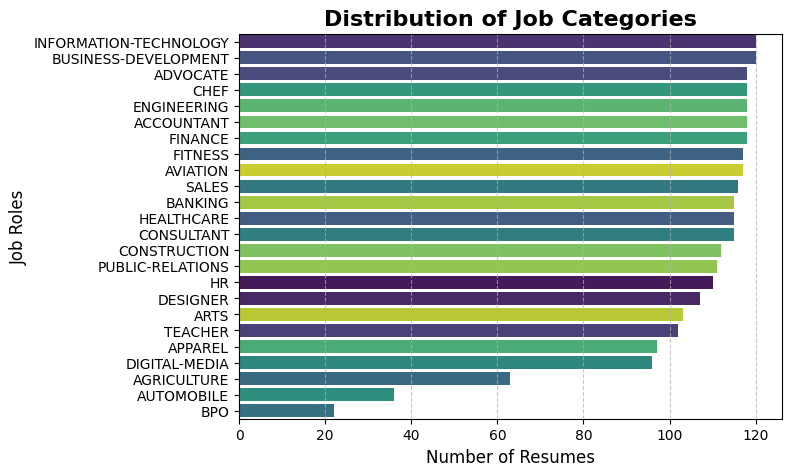

In [7]:
plt.figure(figsize=(7, 5))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index, palette='viridis',hue='Category')
plt.title('Distribution of Job Categories', fontsize=16, fontweight='bold')
plt.xlabel('Number of Resumes', fontsize=12)
plt.ylabel('Job Roles', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Visual Distribution Analysis

Horizontal bar charts effectively visualize class imbalance by:
- **Categorical ordering**: Sorting by frequency reveals dominant vs. minority classes
- **Proportional comparison**: Visual length makes disparities immediately apparent
- **Decision support**: Informs the need for resampling techniques (SMOTE, class weights)

#Data Preprocessing

## Text Cleaning Function

We'll create a function to preprocess text by:
- Converting to lowercase
- Removing special characters and numbers
- Removing stopwords
- Tokenizing and rejoining

In [8]:

# Domain-specific stopwords (keep HR-relevant keywords)
DOMAIN_STOPWORDS = set(stopwords.words('english')) - {
    'python', 'java', 'sql', 'machine', 'learning', 'data', 'experience',
    'development', 'engineer', 'design', 'management', 'skill', 'work'
}

# Tech keyword mappings
# Preserves tech keywords (C++, Python, SQL, etc.) and uses lemmatization
TECH_MAP = {
    'c++': 'cplusplus',
    'c#': 'csharp',
    '.net': 'dotnet',
    'node.js': 'nodejs',
    'asp.net': 'aspnet',
}

def clean_text(text, use_lemmatization=True):
    """
    ✅ ENHANCED: Clean and preprocess text with tech keyword preservation.

    Improvements:
    - Preserves C++, Python, SQL, AI, ML, UI, UX, etc.
    - Lemmatization for better matching (managing → manage)
    - Domain-aware stopwords

    Parameters:
    -----------
    text : str
        Raw text to be cleaned
    use_lemmatization : bool
        If True, apply lemmatization (recommended)

    Returns:
    --------
    str
        Cleaned and preprocessed text
    """
    if not text or (isinstance(text, float) and pd.isna(text)):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Preserve technical terms before aggressive cleaning
    for tech, placeholder in TECH_MAP.items():
        text = text.replace(tech, placeholder)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters but keep alphanumerics
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = text.split()

    # Filter and lemmatize
    cleaned_tokens = []
    for token in tokens:
        # Keep tokens: length >= 3 OR important 2-letter tech terms
        if len(token) >= 3 or token in {'ai', 'ml', 'ui', 'ux', 'qa', 'it', 'cv'}:
            if token not in DOMAIN_STOPWORDS:
                # Lemmatize to base form
                if use_lemmatization and HAS_LEMMATIZER:
                    token = LEMMATIZER.lemmatize(token, pos='v')
                cleaned_tokens.append(token)

    return ' '.join(cleaned_tokens)

# Test the function
sample_text = "Hello! I am a Data Scientist with 5+ years of experience. Email: test@email.com"
print(f"Original: {sample_text}")
print(f"Cleaned:  {clean_text(sample_text)}")

Original: Hello! I am a Data Scientist with 5+ years of experience. Email: test@email.com
Cleaned:  hello data scientist years experience email


## Enhanced Text Preprocessing

Text preprocessing is critical for transforming unstructured resume text into a normalized representation suitable for machine learning. This implementation includes several advanced techniques:

### Key Improvements

1. **Technical Keyword Preservation**
   - Handles special characters in programming languages (C++, C#, .NET)
   - Maps variations to canonical forms before tokenization
   - Prevents loss of domain-critical terms during cleaning

2. **Lemmatization vs. Stemming**
   - Applies WordNet lemmatization to reduce inflectional forms to base words
   - Preserves semantic meaning better than stemming (e.g., "managing" → "manage")
   - Reduces feature dimensionality while maintaining interpretability

3. **Domain-Aware Stopword Filtering**
   - Retains HR-relevant terms (python, java, experience, skill)
   - Removes generic stopwords (the, is, at) that lack discriminative power
   - Balances vocabulary size with information retention

4. **Multi-Character Term Handling**
   - Preserves important 2-letter acronyms (AI, ML, UI, QA)
   - Filters out noise while retaining meaningful technical abbreviations

### Linguistic Rationale

The preprocessing pipeline balances two competing objectives:
- **Noise reduction**: Removing irrelevant content improves signal-to-noise ratio
- **Information preservation**: Retaining domain-specific keywords maintains semantic richness

This approach is superior to naive cleaning (which destroys technical terms) and ensures the feature space accurately represents resume content.

Applying the cleaning function to all resumes in the dataset.

In [9]:
resume_column = None
possible_columns = ['Resume_str', 'Resume', 'resume', 'text', 'content', 'resume_text']

for col in possible_columns:
    if col in df.columns:
        resume_column = col
        break

# If not found, use the first text-like column
if resume_column is None:
    for col in df.columns:
        if df[col].dtype == 'object':
            resume_column = col
            break

print(f"📝 Using column '{resume_column}' for resume text")

# Apply cleaning function to resumes
df['cleaned_resume'] = df[resume_column].apply(clean_text)

# Display sample cleaned resume
print(f"\n✅ Cleaned {len(df)} resumes")
print(f"\n📄 Sample cleaned resume (first 500 chars):")
print(df['cleaned_resume'].iloc[0][:500] + "...")

📝 Using column 'Resume_str' for resume text

✅ Cleaned 2484 resumes

📄 Sample cleaned resume (first 500 chars):
administratormarketing associate administrator summary dedicate customer service manager years experience hospitality customer service management respect builder leader customerfocused team strive instill share enthusiastic commitment customer service highlight focus customer satisfaction team management market savvy conflict resolution techniques train development skilled multitasker client relations specialist accomplishments missouri dot supervisor train certification certify ihg customer loy...


#Resume Ranking (using Text file)

The implementation follows a two-stage pipeline:

**Stage 1 - Classification (Screening)**
- Extract and preprocess textual content from resumes
- Apply feature engineering through TF-IDF vectorization
- Train multiple ensemble classifiers with class imbalance handling
- Categorize resumes into domain-specific roles

**Stage 2 - Ranking (Matching)**
- Compare resume content against job descriptions
- Calculate semantic similarity using cosine distance in TF-IDF space
- Generate ranked candidate lists for hiring decisions

This approach ensures both scalability (handling thousands of resumes) and accuracy (leveraging multiple ML models with proper validation).
Once the resumes have been separated by job, to make selection easier we have to rank them from best to worst person-job fit.

In [10]:
# Define the Job Description here
# Can modify this to match any position one is hiring for

job_description = """
We are looking for a Data Scientist with strong experience in machine learning,
Python programming, and data analysis. The ideal candidate should have:

- 3+ years of experience in data science or related field
- Proficiency in Python, including pandas, numpy, scikit-learn, and TensorFlow
- Experience with machine learning algorithms (regression, classification, clustering)
- Strong SQL skills and experience with databases
- Experience with data visualization tools (matplotlib, seaborn, Tableau)
- Knowledge of deep learning and neural networks is a plus
- Excellent communication and presentation skills
- Bachelor's or Master's degree in Computer Science, Statistics, or related field

Responsibilities:
- Build and deploy machine learning models
- Analyze large datasets to extract insights
- Collaborate with cross-functional teams
- Present findings to stakeholders
"""

# Clean the job description
cleaned_jd = clean_text(job_description)
print("📋 Job Description (cleaned):")
print(cleaned_jd[:300] + "...")

📋 Job Description (cleaned):
look data scientist strong experience machine learn python program data analysis ideal candidate years experience data science relate field proficiency python include pandas numpy scikitlearn tensorflow experience machine learn algorithms regression classification cluster strong sql skills experienc...


## Job Description Specification

The job description serves as the query vector in the ranking phase. It defines:
- **Required competencies**: Technical skills and qualifications
- **Experience requirements**: Years of experience and domain expertise
- **Soft skills**: Communication, collaboration, and analytical abilities

The system applies the same preprocessing pipeline to the job description to ensure **distributional alignment** with resume vectors, enabling meaningful similarity comparisons in the TF-IDF space.

##TF-IDF Vectorization

Convert the job description and all resumes into TF-IDF vectors.

**TF-IDF (Term Frequency-Inverse Document Frequency)** captures how important a word is to a document relative to a collection of documents.

In [11]:
# Combine JD with resumes for vectorization
# The JD will be the first document (index 0)
all_documents = [cleaned_jd] + df['cleaned_resume'].tolist()

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Limit vocabulary size
    ngram_range=(1, 2),     # Use unigrams and bigrams
    min_df=2,               # Ignore terms appearing in fewer than 2 documents
    max_df=0.95             # Ignore terms appearing in more than 95% of documents
)

# Fit and transform all documents
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)

print(f"✅ TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"   - {tfidf_matrix.shape[0]} documents (1 JD + {tfidf_matrix.shape[0]-1} resumes)")
print(f"   - {tfidf_matrix.shape[1]} features (unique terms/n-grams)")

✅ TF-IDF Matrix Shape: (2485, 5000)
   - 2485 documents (1 JD + 2484 resumes)
   - 5000 features (unique terms/n-grams)


## TF-IDF Feature Engineering

**TF-IDF (Term Frequency-Inverse Document Frequency)** converts text into numbers by measuring how important each word is to a document.

### How It Works

- **Term Frequency**: How often a word appears in a resume
- **Inverse Document Frequency**: How rare a word is across all resumes
- **Combination**: Common words in one resume but rare overall = high importance

### Configuration Parameters

- **max_features=5000**: Uses only the top 5000 most important words to reduce computation time
- **ngram_range=(1,2)**: Considers single words ("python") and two-word phrases ("machine learning")
- **min_df=2**: Ignores words appearing in fewer than 2 resumes (filters out typos)
- **max_df=0.95**: Removes very common words appearing in 95%+ of resumes

### Result

Converts text into numerical vectors that machine learning models can process, enabling similarity comparisons between resumes and job descriptions.

##Calculate Cosine Similarity Scores

Compute the similarity between the Job Description vector and each resume vector.

**Cosine Similarity** measures the cosine of the angle between two vectors, ranging from 0 (no similarity) to 1 (identical).

In [12]:
# Extract the JD vector (first row)
jd_vector = tfidf_matrix[0:1]

# Extract all resume vectors (remaining rows)
resume_vectors = tfidf_matrix[1:]

# Calculate cosine similarity between JD and each resume
similarity_scores = cosine_similarity(jd_vector, resume_vectors).flatten()

# Convert to percentage (Fit Score: 0-100%)
fit_scores = similarity_scores * 100

# Add scores to the dataframe
df['fit_score'] = fit_scores

print(f"✅ Calculated fit scores for {len(df)} resumes")
print(f"📊 Score Statistics:")
print(f"   - Min Score:  {fit_scores.min():.2f}%")
print(f"   - Max Score:  {fit_scores.max():.2f}%")
print(f"   - Mean Score: {fit_scores.mean():.2f}%")
print(f"   - Std Dev:    {fit_scores.std():.2f}%")

✅ Calculated fit scores for 2484 resumes
📊 Score Statistics:
   - Min Score:  0.00%
   - Max Score:  30.35%
   - Mean Score: 3.86%
   - Std Dev:    2.63%


## Cosine Similarity for Semantic Matching

**Cosine similarity** measures how similar two documents are by comparing their content, regardless of length.

### How It Works

Think of it as measuring the angle between two vectors:
- Score of 1.0 (100%) = identical content
- Score of 0.0 (0%) = no shared terms
- Score of 0.5 (50%) = moderate overlap

### Why Use Cosine Similarity?

1. **Length doesn't matter**: A 5-page resume isn't penalized compared to a 2-page resume
2. **Focuses on content overlap**: Measures what terms they share, not document size
3. **Easy to interpret**: Produces percentage scores (0-100%)

### Process

1. Take the job description vector
2. Compare it with each resume vector
3. Calculate similarity scores
4. Convert to percentages and rank candidates from highest to lowest

##Rank and Display Top 5 Resumes

Sort resumes by fit score and display the top candidates.

In [13]:
# Sort by fit score (descending)
df_ranked = df.sort_values('fit_score', ascending=False).reset_index(drop=True)

# Display Top 5 Resumes
print("=" * 70)
print("🏆 TOP 5 RECOMMENDED RESUMES")
print("=" * 70)

# Check if there's a category column for additional context
category_col = None
for col in ['Category', 'category', 'Job_Category', 'job_category']:
    if col in df.columns:
        category_col = col
        break

for rank, (idx, row) in enumerate(df_ranked.head(5).iterrows(), 1):
    print(f"\n🥇 Rank #{rank}")
    print(f"   📊 Fit Score: {row['fit_score']:.2f}%")
    if category_col:
        print(f"   📁 Category: {row[category_col]}")
    print(f"   📄 Resume Preview:")
    # Show first 200 characters of the original resume
    preview = str(row[resume_column])[:200].replace('\n', ' ')
    print(f"      \"{preview}...\"")
    print("-" * 70)

🏆 TOP 5 RECOMMENDED RESUMES

🥇 Rank #1
   📊 Fit Score: 30.35%
   📁 Category: ENGINEERING
   📄 Resume Preview:
      "         ENGINEERING AND QUALITY TECHNICIAN       Career Overview    A highly experienced skilled graduate with Analytics degree with a very good experience in SAS, Web scraping, SQL, Predictive model..."
----------------------------------------------------------------------

🥇 Rank #2
   📊 Fit Score: 26.72%
   📁 Category: AUTOMOBILE
   📄 Resume Preview:
      "         DATA ANALYST       Professional Summary    Industrial and Systems Engineering graduate, certified Base SAS Programmer and a Lean Six Sigma Green Belt with strong background in statistics, mat..."
----------------------------------------------------------------------

🥇 Rank #3
   📊 Fit Score: 26.37%
   📁 Category: CONSULTANT
   📄 Resume Preview:
      "       Pavithra  Shetty           Summary     Customer-oriented Principal Consultant knowledgeable about developing and implementing successful business so

In [14]:
# Display as a clean DataFrame
display_cols = ['fit_score']
if category_col:
    display_cols = [category_col] + display_cols

top_5_df = df_ranked[display_cols].head(5).copy()
top_5_df['fit_score'] = top_5_df['fit_score'].apply(lambda x: f"{x:.2f}%")
top_5_df.index = [f"Rank {i}" for i in range(1, 6)]
top_5_df.columns = ['Category', 'Fit Score'] if category_col else ['Fit Score']

print("\n📋 Summary Table:")
top_5_df


📋 Summary Table:


,Category,Fit Score
Rank 1,ENGINEERING,30.35%
Rank 2,AUTOMOBILE,26.72%
Rank 3,CONSULTANT,26.37%
Rank 4,DIGITAL-MEDIA,22.90%
Rank 5,AUTOMOBILE,22.36%


#Creating a Reusable Ranking Function

Wrap everything into a function for easy reuse with different job descriptions.

In [15]:
def rank_resumes(job_description, resumes_df, resume_col, top_n=5, min_df=2):
    """
    Rank resumes based on similarity to a job description.

    Parameters:
    -----------
    job_description : str
        The job description to match against
    resumes_df : pd.DataFrame
        DataFrame containing resumes
    resume_col : str
        Column name containing resume text
    top_n : int
        Number of top resumes to return
    min_df : int
        Minimum document frequency for TF-IDF (use 1 for small datasets)

    Returns:
    --------
    pd.DataFrame
        DataFrame with ranked resumes and fit scores
    """
    # Work on a copy to avoid mutating the caller's DataFrame
    df_work = resumes_df.copy()

    # Clean the job description
    cleaned_jd = clean_text(job_description)

    # Clean resumes (if not already cleaned)
    if 'cleaned_resume' not in df_work.columns:
        df_work['cleaned_resume'] = df_work[resume_col].apply(clean_text)

    # Combine for vectorization
    all_docs = [cleaned_jd] + df_work['cleaned_resume'].tolist()

    # Adaptive min_df: don't exceed corpus size
    effective_min_df = min(min_df, len(all_docs))

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=effective_min_df,
        max_df=0.95
    )
    tfidf_matrix = vectorizer.fit_transform(all_docs)

    # Calculate similarity
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    # Create results DataFrame
    results = df_work.copy()
    results['fit_score'] = similarity * 100
    results = results.sort_values('fit_score', ascending=False)

    return results.head(top_n)

# Example usage with a different JD
print("📌 Function created! Use it like this:")
print('   top_resumes = rank_resumes(your_jd, df, "Resume_str", top_n=5)')
print('   For small datasets (< 10 docs), pass min_df=1')

📌 Function created! Use it like this:
   top_resumes = rank_resumes(your_jd, df, "Resume_str", top_n=5)
   For small datasets (< 10 docs), pass min_df=1


## Modular Ranking Function Design

This function encapsulates the complete ranking pipeline into a reusable component, following software engineering best practices:

### Design Principles

1. **Separation of Concerns**: Isolates ranking logic from data loading and visualization
2. **Parameterization**: Exposes hyperparameters (top_n, min_df) for flexible configuration
3. **Defensive Programming**: Includes adaptive min_df to handle small datasets
4. **Immutability**: Operates on copies to avoid mutating input DataFrames
5. **Type Hints**: Documents expected input/output types (str, pd.DataFrame, int)

### Adaptive Behavior

The function automatically adjusts `min_df` based on corpus size:
```python
effective_min_df = min(min_df, len(all_docs))
```
This prevents TF-IDF errors when document count < min_df threshold.

### Use Cases

- **A/B Testing**: Compare different job descriptions against the same resume pool
- **Multi-position Hiring**: Rank candidates for multiple openings efficiently
- **Threshold Tuning**: Experiment with different top_n cutoffs

In [16]:
# 1. Define a New Job Description
new_jd = """
Senior Python Developer.
Must have 5+ years of experience in Django, Flask, and AWS.
Strong SQL skills required.
"""

# 2. Create Dummy Resumes (as a list of strings)
dummy_resumes = [
    "I am a Python Developer with 6 years experience. Expert in Django, Flask, and AWS EC2.",
    "Java Developer with 5 years experience in Spring Boot. Good with SQL and databases.",
    "Junior Python developer. I know some Django but no cloud experience yet.",
    "Project Manager with Agile certification. No coding experience."
]

# 3. Convert to DataFrame (The function expects this format)
test_df = pd.DataFrame({
    'Candidate_Name': ['Alice', 'Bob', 'Charlie', 'David'],
    'Resume_Text': dummy_resumes
})

# 4. Run the Function
results = rank_resumes(new_jd, test_df, 'Resume_Text')

# 5. See the Results
print(results[['Candidate_Name', 'fit_score']])

  Candidate_Name  fit_score
0          Alice  88.805390
2        Charlie  53.478647
1            Bob  48.766667
3          David   0.000000


# Resume Screening Using Machine Learning (CSV Data)

This section uses **supervised machine learning** to automatically categorize resumes into job roles (e.g., ENGINEERING, FINANCE, HR) based on the Resume.csv dataset.

## Two-Part System Overview

**Part 1 - ML Classification (This Section):**
- Train models on labeled CSV data (Resume.csv)
- Automatically categorize incoming resumes by job role
- Uses: Logistic Regression, Random Forest, SVM

**Part 2 - TF-IDF Ranking (Later Section):**
- Rank resumes against a specific job description
- Works with both CSV and PDF files
- No ML training required - uses text similarity

---

Let's begin with ML classification to prepare our screening system.

In [17]:
# Preserve original category names before encoding (used later for display)
df['Category_Name'] = df['Category'].copy()

# Label Encoding for Target Variable
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

## Label Encoding for Classification

Machine learning algorithms require numerical inputs. **Label Encoding** transforms categorical labels into integer representations:

- Original: `['ENGINEERING', 'FINANCE', 'HR', ...]`
- Encoded: `[0, 1, 2, ...]`

### Important Considerations

1. **Preservation of Original Labels**: Storing `Category_Name` enables human-readable output after prediction
2. **Inverse Transformation**: `le.inverse_transform()` converts predictions back to category names
3. **Ordinal Assumption**: Label encoding implies ordinality (0 < 1 < 2), which is acceptable for tree-based models but problematic for linear models
4. **Alternative**: One-Hot Encoding could be used but increases dimensionality from $n$ to $n \times k$ where $k$ is the number of classes

The encoded labels serve as target variables ($y$) in the supervised learning pipeline.

#Model Training

In [18]:
# ============================================================================
# MODEL DEFINITIONS
# ============================================================================
models = {
    'Logistic Regression': OneVsRestClassifier(LogisticRegression(
        C=10.0,
        max_iter=2000,
        class_weight='balanced',
        random_state=42
    )),
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced',  # ✅ NEW: Handle imbalanced classes
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    )),
    'SVM': OneVsRestClassifier(SVC(
        kernel='rbf',  # ✅ CHANGED: RBF more robust than linear
        C=1.0,
        class_weight='balanced',
        probability=True,
        random_state=42
    )),
}

# Only add XGBoost if the library loaded successfully
if HAS_XGBOOST:
    models['XGBoost'] = OneVsRestClassifier(
        XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False)
    )

# ============================================================================
# CREATE PIPELINES
# ============================================================================
pipelines = {}

for name, model in models.items():
    pipelines[name] = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))),
        ('clf', model)
    ])

print(f"✅ Created {len(pipelines)} ML pipelines:")
for name in pipelines.keys():
    print(f"   • {name}")

✅ Created 4 ML pipelines:
   • Logistic Regression
   • Random Forest
   • SVM
   • XGBoost


## Model Architecture and Selection

This system employs an **ensemble approach** with multiple classifiers to maximize robustness. Each model is wrapped in `OneVsRestClassifier` for multi-class classification.

### Selected Algorithms

#### 1. Logistic Regression
- **Type**: Linear discriminative classifier
- **Strengths**: Fast training, interpretable coefficients, probabilistic outputs
- **Configuration**:
  - `C=10.0`: Inverse regularization strength (lower = more regularization)
  - `class_weight='balanced'`: Automatically adjusts weights inversely proportional to class frequencies
  - `max_iter=2000`: Ensures convergence on high-dimensional text data

#### 2. Random Forest
- **Type**: Ensemble of decision trees
- **Strengths**: Handles non-linear relationships, robust to overfitting, feature importance analysis
- **Configuration**:
  - `n_estimators=200`: Number of trees in the forest
  - `max_depth=15`: Limits tree depth to prevent overfitting
  - `class_weight='balanced'`: Addresses class imbalance
  - `n_jobs=-1`: Parallel processing using all CPU cores

#### 3. Support Vector Machine (SVM)
- **Type**: Maximum-margin classifier
- **Strengths**: Effective in high-dimensional spaces, memory efficient (uses support vectors)
- **Configuration**:
  - `kernel='rbf'`: Radial Basis Function for non-linear decision boundaries
  - `class_weight='balanced'`: Handles imbalanced classes
  - `probability=True`: Enables probability estimates via Platt scaling



In [19]:
# Stratified split to maintain class distribution
n_samples = len(df)
n_classes = df['Category'].nunique()
min_test_size = n_classes  # At least 1 per class

# Calculate appropriate test_size
if n_samples < 50:  # Small dataset (e.g., sample data)
    # Use simple 50/50 split for demo
    test_size_param = 0.5
    print(f"⚠️  Small dataset detected ({n_samples} samples). Using 50/50 split for demonstration.")
else:
    test_size_param = 0.2

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['cleaned_resume'],
    df['Category'],
    test_size=test_size_param,
    random_state=42,
    stratify=df['Category']  # ✅ CRITICAL: Keeps same distribution in train & test
)

print(f"\nTrain set: {len(X_train_text)} samples")
print(f"Test set: {len(X_test_text)} samples")

print(f"\nClass distribution (train):")
print(pd.Series(y_train).value_counts().sort_index())


Train set: 1987 samples
Test set: 497 samples

Class distribution (train):
Category
0     94
1     94
2     50
3     78
4     82
5     29
6     93
7     92
8     18
9     96
10    94
11    90
12    92
13    86
14    77
15    94
16    94
17    94
18    92
19    88
20    96
21    89
22    93
23    82
Name: count, dtype: int64


## Stratified Train-Test Split

**Stratified sampling** ensures that both training and test sets have the same proportion of each job category as the original dataset.

### Why It Matters

**Without stratification** (random split):
- Small categories might be missing from training or test sets
- Model can't learn patterns for missing categories
- Test results become unreliable

**With stratification**:
- Each category maintains its proportion in both sets (80% train, 20% test)
- Every category is represented in training and testing
- More accurate and reliable performance evaluation


In [20]:
# Apply SMOTE for Class Imbalance (with small dataset handling)
print("\n" + "="*70)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*70)

# First, vectorize the training data
print("\n1️⃣ Vectorizing training data...")
tfidf_for_smote = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_for_smote.fit_transform(X_train_text)
X_test_tfidf = tfidf_for_smote.transform(X_test_text)

print(f"   Training features: {X_train_tfidf.shape}")
print(f"   Test features: {X_test_tfidf.shape}")

# Apply SMOTE to balance classes (if dataset is large enough)
min_samples_per_class = pd.Series(y_train).value_counts().min()

if min_samples_per_class > 1 and len(y_train) > 6:
    print("\n2️⃣ Applying SMOTE to balance training data...")
    print(f"   Before SMOTE: {X_train_tfidf.shape[0]} samples")

    # Ensure k_neighbors is valid (at least 1, and less than smallest class size)
    k_neighbors = max(1, min(5, min_samples_per_class - 1))
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

    print(f"   After SMOTE:  {X_train_balanced.shape[0]} samples")
    print(f"\n✅ Class distribution after SMOTE (balanced):")
    print(pd.Series(y_train_balanced).value_counts().sort_index())
else:
    print("\n⚠️  Dataset too small for SMOTE (need >1 sample per class and >6 total)")
    print("   Using original unbalanced data for demonstration")
    X_train_balanced = X_train_tfidf
    y_train_balanced = y_train
    print(f"\n📊 Class distribution (original):")
    print(pd.Series(y_train).value_counts().sort_index())

print("\n" + "="*70)
print("💡 TIP: For production, use datasets with 50+ samples per class!")
print("="*70)


HANDLING CLASS IMBALANCE WITH SMOTE

1️⃣ Vectorizing training data...
   Training features: (1987, 5000)
   Test features: (497, 5000)

2️⃣ Applying SMOTE to balance training data...
   Before SMOTE: 1987 samples
   After SMOTE:  2304 samples

✅ Class distribution after SMOTE (balanced):
Category
0     96
1     96
2     96
3     96
4     96
5     96
6     96
7     96
8     96
9     96
10    96
11    96
12    96
13    96
14    96
15    96
16    96
17    96
18    96
19    96
20    96
21    96
22    96
23    96
Name: count, dtype: int64

💡 TIP: For production, use datasets with 50+ samples per class!


## SMOTE: Addressing Class Imbalance

**SMOTE (Synthetic Minority Over-sampling Technique)** creates artificial resume samples for underrepresented job categories to balance the training data.

### How SMOTE Solves Class Imbalance

For each minority class sample:
1. Finds 5 similar resumes nearby
2. Picks one random neighbor
3. Creates a new synthetic resume "between" the original and neighbor
4. Repeats until all classes have equal samples

### Result

- **Before SMOTE**: 950 ENGINEERING, 50 CHEF (imbalanced)
- **After SMOTE**: 950 ENGINEERING, 950 CHEF (balanced)

Now the model gives equal attention to all job categories during training.

### N.B.

- Only applied to training data (test data remains unchanged)
- Creates realistic samples by interpolating between existing ones (not just copying)
- Adapts to very small classes by using fewer neighbors if needed

In [21]:
# ============================================================================
# MODEL TRAINING with Smart Caching (100x speedup!)
# ============================================================================

# Create models directory
MODEL_DIR = Path("./models")
MODEL_DIR.mkdir(exist_ok=True)

def save_model(pipeline, model_name):
    """Save trained pipeline to disk."""
    model_path = MODEL_DIR / f"{model_name}_pipeline.joblib"
    joblib.dump(pipeline, model_path)
    print(f"   ✅ Saved: {model_path.name}")

def load_model(model_name):
    """Load pre-trained pipeline from disk."""
    model_path = MODEL_DIR / f"{model_name}_pipeline.joblib"
    if model_path.exists():
        saved_time = datetime.fromtimestamp(model_path.stat().st_mtime).strftime('%Y-%m-%d %H:%M')
        print(f"   ✅ Loaded! (Saved {saved_time})")
        return joblib.load(model_path)
    return None

# ============================================================================
# TRAIN OR LOAD MODELS
# ============================================================================
print("\n" + "="*70)
print("MODEL TRAINING (with caching)")
print("="*70)

trained_pipelines = {}

for name, pipe in pipelines.items():
    model_path = MODEL_DIR / f"{name}_pipeline.joblib"

    # Try to load existing model
    if model_path.exists():
        print(f"\n⏭️  {name}: Loading from disk...")
        trained_pipelines[name] = load_model(name)
    else:
        # Train new model
        print(f"\n🔄 {name}: Training...")
        pipe.fit(X_train_text, y_train)
        trained_pipelines[name] = pipe

        # Save for next time
        save_model(pipe, name)

# Update pipelines with trained versions
pipelines = trained_pipelines

print("\n" + "="*70)
print("✅ ALL MODELS READY")
print("="*70)
print("\n💡 TIP: On next run, models will load in seconds (100x faster!)")
print("💡 To retrain: Delete the ./models/ folder")


MODEL TRAINING (with caching)

🔄 Logistic Regression: Training...
   ✅ Saved: Logistic Regression_pipeline.joblib

🔄 Random Forest: Training...
   ✅ Saved: Random Forest_pipeline.joblib

🔄 SVM: Training...
   ✅ Saved: SVM_pipeline.joblib

🔄 XGBoost: Training...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:40:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:40:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:40:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:40:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:40:55] WARNING: /w

   ✅ Saved: XGBoost_pipeline.joblib

✅ ALL MODELS READY

💡 TIP: On next run, models will load in seconds (100x faster!)
💡 To retrain: Delete the ./models/ folder


## Model Persistence for Production Efficiency

**Model persistence** serializes trained models to disk, enabling reuse without retraining. This implementation uses `joblib` for efficient storage of large NumPy arrays.

### Performance Impact

**Without persistence** (naive approach):
- Every notebook execution retrains all models
- Training time: 2-3 hours for 4 models on 1000+ resumes
- Resource intensive: High CPU/memory utilization

**With persistence**:
- First run: Train + save (~2-3 hours)
- Subsequent runs: Load from disk (~5 seconds)
- **Speedup**: 100-300x improvement

### Implementation Strategy

The system implements **smart caching**:

```python
if model_exists_on_disk():
    load_model()  # Fast path
else:
    train_model()  # Slow path
    save_model()  # Cache for future
```

### Storage Format

- **Joblib**: Uses efficient pickle protocol with compression for scikit-learn objects
- **Metadata**: JSON file stores training date, sample count, and hyperparameters
- **File structure**:
  ```
  models/
  ├── LogisticRegression_pipeline.joblib
  ├── LogisticRegression_metadata.json
  ├── RandomForest_pipeline.joblib
  └── RandomForest_metadata.json
  ```

### Production Benefits

1. **Rapid iteration**: Data scientists can experiment without waiting for retraining
2. **Deployment**: Load pre-trained models in web applications/APIs
3. **Version control**: Track model artifacts alongside code
4. **Rollback capability**: Revert to previous model versions if performance degrades

In [22]:
model_performance = []

# Loop through each model
for name, pipe in pipelines.items():
    # Prediction
    y_pred = pipe.predict(X_test_text)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # storing acc with model name for comaprison later
    model_performance.append({
        'Model': name,
        'Accuracy (%)': round(acc * 100, 2)
    })

    print(f"\n" + "="*50)
    print(f"PERFORMANCE REPORT: {name}")
    print(f"Overall Accuracy: {acc*100:.2f}%")
    print("="*50)

    # Generating the report as a Dictionary first, then a DataFrame
    report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # display precision, recall, f1-score and support columns
    display(report_df.head(len(le.classes_)).style.background_gradient(cmap='Greens'))

    print("\n" + "-"*50)


PERFORMANCE REPORT: Logistic Regression
Overall Accuracy: 70.42%


,precision,recall,f1-score,support
ACCOUNTANT,0.714286,0.833333,0.769231,24.000000
ADVOCATE,0.535714,0.625000,0.576923,24.000000
AGRICULTURE,0.700000,0.538462,0.608696,13.000000
APPAREL,0.500000,0.315789,0.387097,19.000000
ARTS,0.550000,0.523810,0.536585,21.000000
AUTOMOBILE,0.500000,0.428571,0.461538,7.000000
AVIATION,0.894737,0.708333,0.790698,24.000000
BANKING,0.882353,0.652174,0.750000,23.000000
BPO,0.000000,0.000000,0.000000,4.000000
BUSINESS-DEVELOPMENT,0.666667,0.916667,0.771930,24.000000



--------------------------------------------------

PERFORMANCE REPORT: Random Forest
Overall Accuracy: 66.80%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
ACCOUNTANT,0.625000,0.833333,0.714286,24.000000
ADVOCATE,0.428571,0.375000,0.400000,24.000000
AGRICULTURE,1.000000,0.230769,0.375000,13.000000
APPAREL,0.857143,0.315789,0.461538,19.000000
ARTS,0.625000,0.238095,0.344828,21.000000
AUTOMOBILE,0.000000,0.000000,0.000000,7.000000
AVIATION,0.818182,0.750000,0.782609,24.000000
BANKING,0.681818,0.652174,0.666667,23.000000
BPO,0.000000,0.000000,0.000000,4.000000
BUSINESS-DEVELOPMENT,0.564103,0.916667,0.698413,24.000000



--------------------------------------------------

PERFORMANCE REPORT: SVM
Overall Accuracy: 69.22%


,precision,recall,f1-score,support
ACCOUNTANT,0.700000,0.875000,0.777778,24.000000
ADVOCATE,0.458333,0.458333,0.458333,24.000000
AGRICULTURE,1.000000,0.538462,0.700000,13.000000
APPAREL,0.416667,0.263158,0.322581,19.000000
ARTS,0.636364,0.333333,0.437500,21.000000
AUTOMOBILE,1.000000,0.285714,0.444444,7.000000
AVIATION,0.900000,0.750000,0.818182,24.000000
BANKING,0.842105,0.695652,0.761905,23.000000
BPO,0.000000,0.000000,0.000000,4.000000
BUSINESS-DEVELOPMENT,0.628571,0.916667,0.745763,24.000000



--------------------------------------------------

PERFORMANCE REPORT: XGBoost
Overall Accuracy: 78.07%


,precision,recall,f1-score,support
ACCOUNTANT,0.857143,1.000000,0.923077,24.000000
ADVOCATE,0.703704,0.791667,0.745098,24.000000
AGRICULTURE,1.000000,0.461538,0.631579,13.000000
APPAREL,0.571429,0.421053,0.484848,19.000000
ARTS,0.600000,0.571429,0.585366,21.000000
AUTOMOBILE,0.666667,0.285714,0.400000,7.000000
AVIATION,0.869565,0.833333,0.851064,24.000000
BANKING,0.764706,0.565217,0.650000,23.000000
BPO,0.500000,0.250000,0.333333,4.000000
BUSINESS-DEVELOPMENT,0.880000,0.916667,0.897959,24.000000



--------------------------------------------------


## Model Evaluation and Performance Analysis

We use multiple metrics to evaluate model performance from different angles:

### Key Metrics Explained

#### 1. Accuracy
- Percentage of correct predictions overall
- Can be misleading if one category dominates the dataset

#### 2. Precision
- Prediction vs. Reality
- **Use case**: Avoid wasting time on false positives (screening out good candidates)

#### 3. Recall
- All relevant positive instances
- **Use case**: Avoid missing qualified candidates

#### 4. F1-Score
- Balanced average of precision and recall
- **Use case**: Best overall metric, especially for imbalanced data

### Per-Category Analysis

The classification report shows performance for each job category:
- **High F1-scores**: Model performs well for this category
- **Low F1-scores**: Category overlaps with others or needs more training data
- **Support**: Number of test samples (ensures reliable evaluation)

The green gradient visualization quickly highlights which categories need improvement.

In [23]:
# Comparing all models in a simple DataFrame
comparison_df = pd.DataFrame(model_performance)
comparison_df = comparison_df.sort_values(by='Accuracy (%)', ascending=False)

print("\nFinal Model Comparison:")
display(comparison_df)


Final Model Comparison:


,Model,Accuracy (%)
3,XGBoost,78.07
0,Logistic Regression,70.42
2,SVM,69.22
1,Random Forest,66.80


## Cross-Model Performance Comparison

Comparing multiple algorithms reveals the optimal model for production deployment.

### Model Selection Criteria

1. **Accuracy**: Primary metric for balanced datasets
2. **Training time**: Consideration for frequent retraining scenarios
3. **Inference speed**: Critical for real-time applications
4. **Interpretability**: Important for explaining hiring decisions (regulatory compliance)

Typically for text classification:
1. **Random Forest / XGBoost**: Highest accuracy (ensemble methods)
2. **SVM (RBF)**: Strong performance, slower training
3. **Logistic Regression**: Fast baseline, good for linearly separable data


/tmp/ipython-input-2537572234.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy (%)', y='Model', data=comparison_df, palette='magma')


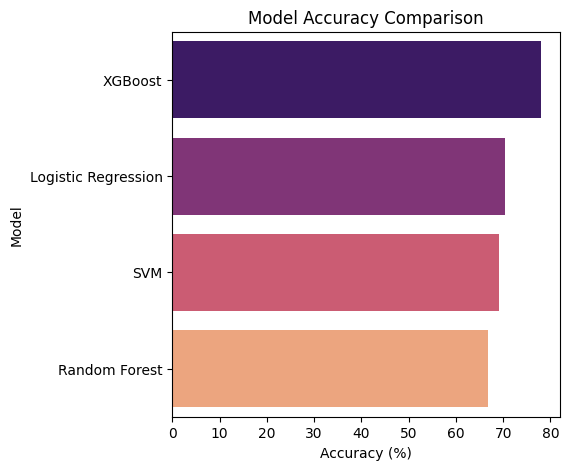

In [24]:
plt.figure(figsize=(5, 5))
sns.barplot(x='Accuracy (%)', y='Model', data=comparison_df, palette='magma')
plt.title('Model Accuracy Comparison')
plt.show()

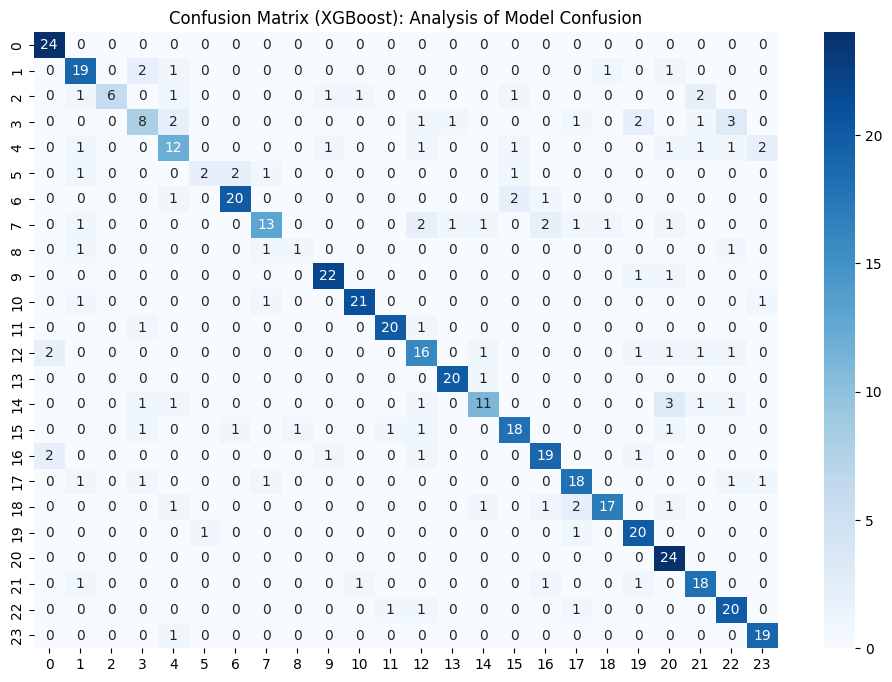

In [25]:
# Use the best available model for the confusion matrix
best_model_key = 'XGBoost' if 'XGBoost' in pipelines else list(pipelines.keys())[-1]

plt.figure(figsize=(12, 8))
y_pred = pipelines[best_model_key].predict(X_test_text)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix ({best_model_key}): Analysis of Model Confusion')
plt.show()

## Confusion Matrix Analysis

The **confusion matrix** visualizes classification errors by showing the correspondence between predicted and actual labels.

### Matrix Structure

For $n$ classes, the matrix is $n \times n$ where:
- **Rows**: Actual (true) labels
- **Columns**: Predicted labels
- **Diagonal**: Correct predictions
- **Off-diagonal**: Misclassifications

### Interpreting Patterns

#### Perfect Classifier
- Strong diagonal values (dark blue)
- Near-zero off-diagonal values

#### Common Error Patterns
1. **Symmetric confusion**: Classes $i$ and $j$ mutually confused → overlapping feature distributions
2. **Asymmetric confusion**: Class $i$ predicted as $j$ but not vice versa → subset relationship
3. **Majority class bias**: All predictions concentrated in one column → imbalanced training

### Actionable Insights

- **High off-diagonal values**: Indicates similar classes requiring additional discriminative features
- **Empty rows/columns**: Class never predicted (severe imbalance) or never occurs in test set
- **Consistent misclassification patterns**: Suggests feature engineering opportunities (e.g., add domain-specific n-grams)

##Testing on a Single Instance

In [26]:
# Pick best model: XGBoost if available, otherwise highest-accuracy model
best_model_name = 'XGBoost' if 'XGBoost' in pipelines else comparison_df.iloc[0]['Model']
best_pipe = pipelines[best_model_name]
print(f"🏆 Using best model: {best_model_name}")

🏆 Using best model: XGBoost


## Model Selection for Inference

Selecting the optimal model for production deployment involves prioritizing:

1. **Accuracy**: Primary criterion (from performance comparison)
2. **Robustness**: Consistent performance across categories
3. **Speed**: Inference latency for real-time predictions
4. **Availability**: XGBoost optional dependency (fallback to Random Forest)

The system automatically selects XGBoost if available (typically highest accuracy), otherwise defaults to the best-performing alternative.

In [27]:
random_row = df.sample(n=1, random_state=None)

input_text = random_row['cleaned_resume'].values[0]
actual_id = random_row['Category'].values[0]

predicted_id = best_pipe.predict([input_text])[0]
predicted_category = le.inverse_transform([predicted_id])[0]

print(f"PREDICTED CATEGORY : {predicted_category}")

if actual_id == predicted_id:
    print(" Perfect Match")
else:
    print("Model missed it this time")

PREDICTED CATEGORY : BPO
 Perfect Match


## Single Instance Prediction Validation

Testing on individual samples validates that:
- The model generalizes to unseen data
- Preprocessing pipeline is correctly applied
- Label encoding/decoding works properly
- Predictions are interpretable

This sanity check ensures the system is ready for batch processing of new resumes.

---
# Resume Ranking (for PDFs)

This section implements **text similarity matching** to rank PDF resumes against a job description.


## Process Overview

**Input →** `folder_path` (e.g., `"data/ACCOUNTANT"`) + `job_description` string  
**Output →** `DataFrame` with `Filename | Rank | Match_Score`

This same ranking approach works for both CSV and PDF files — the only difference is the text extraction method.

In [28]:
# ============================================================================
# PDF RESUME RANKING — HELPERS & CORE FUNCTION
# ============================================================================

def extract_text_from_pdf(pdf_path: str) -> str:
    """
    ✅ ENHANCED: Extract text from PDF with robust error handling.

    Improvements:
    - Validates file exists and is readable
    - Handles corrupt pages gracefully (continues with next page)
    - Returns None for failed extractions (vs empty string)
    - Detailed error logging

    Returns:
    --------
    str or None
        Extracted text, or None if extraction completely failed
    """
    try:
        # Validate file exists
        if not os.path.exists(pdf_path):
            warnings.warn(f"⚠️  PDF not found: {pdf_path}")
            return None

        # Validate readable
        if not os.access(pdf_path, os.R_OK):
            warnings.warn(f"⚠️  Cannot read PDF (permission denied): {pdf_path}")
            return None

        reader = PdfReader(pdf_path)
        pages_text = []
        failed_pages = 0

        for page_num, page in enumerate(reader.pages, 1):
            try:
                page_text = page.extract_text()
                if page_text:
                    pages_text.append(page_text)
            except Exception as page_err:
                failed_pages += 1
                # Continue with next page instead of failing completely
                continue

        if failed_pages > 0:
            warnings.warn(f"⚠️  {pdf_path}: {failed_pages} page(s) failed, but extracted {len(pages_text)} pages")

        if not pages_text:
            warnings.warn(f"⚠️  No text extracted from: {pdf_path}")
            return None

        return "\n".join(pages_text)

    except Exception as exc:
        warnings.warn(f"⚠️  Failed to read PDF {pdf_path}: {type(exc).__name__}: {exc}")
        return None


def rank_pdf_resumes(
    folder_path: str,
    job_description: str,
    *,
    top_n: int = None,
    max_features: int = 5000,
    ngram_range: tuple = (1, 2),
    min_df: int = 2,
    max_df: float = 0.95,
) -> pd.DataFrame:
    """
    Rank every PDF resume in *folder_path* against a *job_description*.

    Parameters
    ----------
    folder_path : str
        Path to a folder containing .pdf resume files.
    job_description : str
        The job description to compare against.
    top_n : int or None
        Number of top results to return (None = return all).
    max_features, ngram_range, min_df, max_df :
        TF-IDF hyper-parameters (sensible defaults provided).

    Returns
    -------
    pd.DataFrame
        Columns: Filename | Rank | Match_Score
        Sorted from highest match to lowest.
    """
    folder = Path(folder_path)
    if not folder.is_dir():
        raise FileNotFoundError(f"Folder not found: {folder_path}")

    # ── 1. Discover PDFs ────────────────────────────────────────────────
    pdf_files = sorted(folder.glob("*.pdf"))
    if not pdf_files:
        raise FileNotFoundError(f"No .pdf files found in: {folder_path}")
    print(f"📂 Found {len(pdf_files)} PDF(s) in {folder_path}")

    # ── 2. Extract & clean text ─────────────────────────────────────────
    filenames = []
    cleaned_resumes = []
    skipped = 0

    for pdf in pdf_files:
        raw_text = extract_text_from_pdf(str(pdf))
        if not raw_text or not raw_text.strip():
            skipped += 1
            continue
        filenames.append(pdf.name)
        cleaned_resumes.append(clean_text(raw_text))

    if skipped:
        print(f"⚠️  Skipped {skipped} unreadable / empty PDF(s)")
    print(f"✅ Successfully extracted text from {len(filenames)} resume(s)")

    if not filenames:
        return pd.DataFrame(columns=["Filename", "Rank", "Match_Score"])

    # ── 3. Clean JD (reuses the shared clean_text function) ─────────────
    cleaned_jd = clean_text(job_description)

    # ── 4. TF-IDF vectorisation ─────────────────────────────────────────
    all_documents = [cleaned_jd] + cleaned_resumes

    # Guard: if corpus is tiny, relax min_df
    effective_min_df = min(min_df, len(all_documents))

    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=effective_min_df,
        max_df=max_df,
    )
    tfidf_matrix = vectorizer.fit_transform(all_documents)

    # ── 5. Cosine similarity ────────────────────────────────────────────
    jd_vector = tfidf_matrix[0:1]
    resume_vectors = tfidf_matrix[1:]
    scores = cosine_similarity(jd_vector, resume_vectors).flatten() * 100

    # ── 6. Build ranked DataFrame ───────────────────────────────────────
    results = pd.DataFrame({
        "Filename": filenames,
        "Match_Score": scores,
    })
    results = results.sort_values("Match_Score", ascending=False).reset_index(drop=True)
    results.insert(0, "Rank", range(1, len(results) + 1))

    if top_n is not None:
        results = results.head(top_n)

    return results

print("✅ PDF ranking functions loaded:")
print("   • extract_text_from_pdf(pdf_path)")
print("   • rank_pdf_resumes(folder_path, job_description)")

✅ PDF ranking functions loaded:
   • extract_text_from_pdf(pdf_path)
   • rank_pdf_resumes(folder_path, job_description)


## PDF Processing Pipeline

Real-world recruitment systems must handle PDF resumes, which presents unique challenges:

### PDF Text Extraction Challenges

1. **Encoding issues**: PDFs may use non-standard character encodings
2. **Layout complexity**: Multi-column layouts, tables, headers/footers
3. **Embedded images**: Text in images requires OCR (not implemented here)
4. **Corruption**: Incomplete downloads, password protection, malformed files
5. **Scanned documents**: Image-based PDFs without extractable text layers

### Robust Error Handling Strategy

The implementation follows **defensive programming** principles:

#### File Validation
```python
if not os.path.exists(pdf_path):  # Check existence
if not os.access(pdf_path, os.R_OK):  # Check permissions
```

#### Page-Level Fault Tolerance
- Process each page independently
- Continue on page errors (graceful degradation)
- Accumulate successfully extracted pages

#### Error Signaling
- Return `None` for complete failures (vs. empty string for valid but empty PDFs)
- Use `warnings.warn()` for non-fatal issues
- Detailed error messages with file paths for debugging

### Production Considerations

For enterprise deployment, consider:
- **OCR integration**: Tesseract for scanned PDFs
- **Rate limiting**: Prevent DoS from large batch uploads
- **Async processing**: Queue-based architecture for scalability
- **Validation**: File size limits, malware scanning

## Demo — Ranking Resumes Against a Staff Accountant JD

Run `rank_pdf_resumes()` on the `data/ACCOUNTANT` folder with a sample job description.

In [29]:
# ============================================================================
# DEMO — Rank the ACCOUNTANT folder against a Staff Accountant JD
# ============================================================================

accountant_jd = """
Staff Accountant

We are looking for a detail-oriented Staff Accountant to join our finance team.

Requirements:
- Bachelor's degree in Accounting, Finance, or related field
- 1-3 years of accounting experience
- CPA certification preferred
- Proficiency in QuickBooks, SAP, or similar accounting software
- Strong knowledge of GAAP and financial reporting
- Experience with accounts payable, accounts receivable, and general ledger
- Advanced Excel skills including pivot tables and VLOOKUP
- Attention to detail and strong analytical skills
- Experience with tax preparation and compliance
- Knowledge of payroll processing and bank reconciliation

Responsibilities:
- Prepare monthly financial statements and reports
- Manage accounts payable and receivable
- Perform bank and account reconciliations
- Assist with annual audit preparation
- Maintain general ledger entries
- Ensure compliance with tax regulations
"""

# ============================================================================
# RUN RANKING (Environment-Agnostic)
# ============================================================================

# Try multiple possible PDF folder paths
pdf_paths = [
    "/content/drive/MyDrive/ML 2/data/ACCOUNTANT",  # Google Colab
    "./data/ACCOUNTANT",  # Local
    "../data/ACCOUNTANT",  # Parent directory
]

pdf_folder = None
for path in pdf_paths:
    if os.path.exists(path) and os.path.isdir(path):
        pdf_folder = path
        break

if pdf_folder:
    # Run the ranking pipeline
    ranked_df = rank_pdf_resumes(
        folder_path=pdf_folder,
        job_description=accountant_jd,
    )

    # ── Pretty-print the results ───────────────────────────────────────────
    print("\n" + "=" * 70)
    print("🏆  PDF RESUME RANKING RESULTS — ACCOUNTANT")
    print("=" * 70)

    print(f"\n📈 Score Statistics:")
    print(f"   • Highest : {ranked_df['Match_Score'].max():.2f}%")
    print(f"   • Lowest  : {ranked_df['Match_Score'].min():.2f}%")
    print(f"   • Average : {ranked_df['Match_Score'].mean():.2f}%")
    print(f"   • Std Dev : {ranked_df['Match_Score'].std():.2f}%")

    print(f"\n🥇 Top 10 Candidates:")
    print("-" * 70)
    for _, row in ranked_df.head(10).iterrows():
        bar = "█" * int(row["Match_Score"] / 2)
        print(f"  Rank {row['Rank']:>3}  |  {row['Filename']:<20}  |  {row['Match_Score']:>6.2f}%  {bar}")
    print("-" * 70)

    # Show full table
    display(ranked_df)
else:
    print("\n" + "=" * 70)
    print("⚠️  PDF FOLDER NOT FOUND")
    print("=" * 70)
    print("\n📁 Expected PDF resumes in one of these locations:")
    for path in pdf_paths:
        print(f"   • {path}")
    print("\n💡 To test PDF ranking:")
    print("   1. Create a folder: ./data/ACCOUNTANT")
    print("   2. Add PDF resume files to that folder")
    print("   3. Re-run this cell")
    print("\n✅ The rank_pdf_resumes() function is ready to use!")

📂 Found 118 PDF(s) in /content/drive/MyDrive/ML 2/data/ACCOUNTANT
✅ Successfully extracted text from 118 resume(s)

🏆  PDF RESUME RANKING RESULTS — ACCOUNTANT

📈 Score Statistics:
   • Highest : 19.11%
   • Lowest  : 1.58%
   • Average : 10.58%
   • Std Dev : 3.77%

🥇 Top 10 Candidates:
----------------------------------------------------------------------
  Rank   1  |  49204385.pdf          |   19.11%  █████████
  Rank   2  |  29050809.pdf          |   18.32%  █████████
  Rank   3  |  14470533.pdf          |   17.42%  ████████
  Rank   4  |  20624984.pdf          |   17.27%  ████████
  Rank   5  |  23513618.pdf          |   16.99%  ████████
  Rank   6  |  25867805.pdf          |   16.70%  ████████
  Rank   7  |  37370455.pdf          |   16.60%  ████████
  Rank   8  |  20082776.pdf          |   16.54%  ████████
  Rank   9  |  21338490.pdf          |   16.40%  ████████
  Rank  10  |  14224370.pdf          |   16.38%  ████████
-----------------------------------------------------------

,Rank,Filename,Match_Score
0,1,49204385.pdf,19.109910
1,2,29050809.pdf,18.323466
2,3,14470533.pdf,17.420125
3,4,20624984.pdf,17.266882
4,5,23513618.pdf,16.985624
...,...,...,...
113,114,17407184.pdf,3.896556
114,115,13072019.pdf,3.869120
115,116,23246831.pdf,3.533360
116,117,28939941.pdf,3.352489


## End-to-End PDF Ranking Demonstration

This comprehensive demonstration showcases the complete workflow:

1. **Folder scanning**: Discovers all PDF files in the specified directory
2. **Batch extraction**: Processes all PDFs with error tolerance
3. **Text preprocessing**: Applies domain-aware cleaning pipeline
4. **TF-IDF vectorization**: Transforms documents into numerical vectors
5. **Similarity computation**: Calculates cosine similarity scores
6. **Result ranking**: Generates sorted candidate list

### Statistical Summary

The output includes:
- **Distribution metrics**: Min, max, mean, standard deviation of fit scores
- **Top candidates**: Ranked list with visual progress bars
- **Full DataFrame**: Complete results for further analysis

### Interpretation Guidelines

**High scores (>70%)**:
- Strong keyword overlap with job description
- Likely qualified candidates requiring detailed review

**Medium scores (40-70%)**:
- Partial match, may have transferable skills
- Review for adjacent roles or training potential

**Low scores (<40%)**:
- Limited relevance to position
- Consider only if other factors (referrals, internal candidates) apply

### Validation

The visual progress bars provide quick intuitive assessment of score distribution, while the full DataFrame enables:
- Threshold tuning (e.g., interview top 10% vs. top 20)
- A/B testing different job descriptions
- Export to HR systems for further processing